# ブラックボックス最適化を用いた広告配信最適化

ブラックボックス最適化を利用して広告配信の最適化をやってみましょう。  
広告配信において以下のようなパラメータを調整します。

- 入札戦略（CPC, CPM, CPA, ROAS）
- ターゲティング粒度（性別のみ、年代別、詳細デモグラ、行動履歴）
- 配信デバイス（PC、スマホ、タブレット、全デバイス）
- 配信時間帯（全日、平日昼、夜間、週末）
- クリエイティブ形式（バナー、動画、ネイティブ、リッチメディア）
- 頻度制御（制限なし、日3回、週5回、月10回）
- オーディエンス戦略（類似、リターゲティング、興味関心、新規）
- 予算配分
- 入札額
- ターゲット年齢幅

ここではチュートリアル用に用意しているシミュレータを使って広告配信の最適化を行います。

このシミュレータは上記のパラメータをインプットとし、

- CTR (Click Through Rate): クリック率
- CVR (Conversion Rate): コンバージョン率
- CPC (Cost Per Click): クリック単価
- CPA (Cost Per Acquisition): 獲得単価
- ROAS (Return on Ad Spend): 広告費対効果

を出力します。

このシミュレータは内部で
- モバイル×行動ターゲティングの相乗効果
- 動画×リターゲティングの高いコンバージョン
- 夕方×モバイルの時間帯効果
- CPA入札×行動ターゲティングの最適化効果
のような相互作用を考慮しています。

まずは簡単にシミュレータを使ってみましょう。

JijZeptToolsでは `jijzepttools.blackbox_optimization.demo` の中にいくつかデモ用のシミュレータが用意されています。そこから広告配信のシミュレータをインポートして使います。

In [1]:
import jijzepttools.blackbox_optimization.demo.ad_simulator as ad_sim

## 広告配信シミュレータを使ってみよう

こちらが設定できないマーケットのパラメータを設定しましょう。

In [2]:
# 市場環境の設定
market = ad_sim.MarketConditions(
    competition_level=0.7,
    market_saturation=0.4,
    seasonal_factor=1.2,
    economic_index=1.1,
)

次に広告配信戦略に対応するパラメータを設定します。このパラメータがシミュレータのインプットとなります。


In [3]:
ad_sim_params = ad_sim.AdCampaignParams(
    bidding_strategy=ad_sim.BiddingStrategy.CPC,
    targeting_granularity=ad_sim.TargetingGranularity.AGE_GROUP,
    device_target=ad_sim.DeviceTarget.ALL_DEVICES,
    time_slot=ad_sim.TimeSlot.ALL_DAY,
    creative_format=ad_sim.CreativeFormat.BANNER,
    frequency_cap=ad_sim.FrequencyCap.DAILY_3,
    audience_strategy=ad_sim.AudienceStrategy.INTEREST,
    budget_allocation=1.0,
    bid_amount=150,
    target_age_range=30,
)

このパラメータをrunnerに渡してシミュレータを実行します。

In [4]:
runner = ad_sim.AdCampaignRunner(market_conditions=market)
result = runner.analyze_campaign(ad_sim_params)
result

{'ctr': 0.01320148047315424,
 'cvr': 0.034780468250565445,
 'cpc': 135.83788652481957,
 'cpa': 3905.5795783488675,
 'roas': 0.025604394429539764,
 'total_score': 0.254137059895093,
 'constraints_satisfied': True,
 'constraint_violations': []}

ではこのシミュレータを利用したブラックボックス関数を作っておきましょう。JijZeptToolsが対応しているブラックボックス関数は`dict[str, str | float]`を受け取るのでrunnerのインターフェースと合わせるためにEnumへの変換を実装しておく必要があります。

In [5]:
def ad_campaign_blackbox_func(params: dict):
    ad_params = ad_sim.AdCampaignParams(
        bidding_strategy=ad_sim.BiddingStrategy(params['bidding_strategy']),
        targeting_granularity=ad_sim.TargetingGranularity(params['targeting_granularity']),
        device_target=ad_sim.DeviceTarget(params['device_target']),
        time_slot=ad_sim.TimeSlot(params['time_slot']),
        creative_format=ad_sim.CreativeFormat(params['creative_format']),
        frequency_cap=ad_sim.FrequencyCap(params['frequency_cap']),
        audience_strategy=ad_sim.AudienceStrategy(params['audience_strategy']),
        budget_allocation=params['budget_allocation'],
        bid_amount=params['bid_amount'],
        target_age_range=params['target_age_range'],
    )
    return runner.analyze_campaign(ad_params)

## ブラックボックス最適化

### 決定変数の設定

JijZeptToolsではブラックボックス最適化を行うための`jijzepttools.blackbox_optimization`モジュールが用意されています。まず`BlackBoxkProblem`クラスのオブジェクトを作成し、決定変数を設定します。

- Binary: 0 or 1
- Categorical: 文字列のリストをcategoryとして設定し、そのうちの一つを選ぶ。
- Integer: int
- Continuous: float

の4つの変数を利用することができます。

`.add_*`メソッドを使って決定変数を追加することができます。また、`.add_*`メソッドはJijModelingの決定変数オブジェクトを返します。あとからそのオブジェクトを使って制約条件を追加することができます。まずはそういった制約条件の追加は無しで決定変数を設定していきましょう。

In [6]:
from jijzepttools.blackbox_optimization.bbo_ommx import BlackboxProblem
import jijmodeling as jm

bb_model = BlackboxProblem('ad opt', description='広告キャンペーン最適化', sense=jm.ProblemSense.MAXIMIZE)

bidding_strategy = bb_model.add_CategoricalVar('bidding_strategy',
                          ['CPC', 'CPA', 'CPM'])
targeting_granularity = bb_model.add_CategoricalVar('targeting_granularity',
                          ['age_group', 'detailed_demo', 'gender_only', 'behavioral'])
bb_model.add_CategoricalVar('device_target',
                          ['all_devices', 'mobile', 'pc', 'tablet'])
bb_model.add_CategoricalVar('time_slot',
                          ['all_day', 'evening', 'weekday_daytime', 'weekend'])
creative_format = bb_model.add_CategoricalVar('creative_format',
                          ['banner', 'video', 'native', 'rich_media'])
bb_model.add_CategoricalVar('frequency_cap',
                          ['daily_3', 'weekly_5', 'no_limit'])
bb_model.add_CategoricalVar('audience_strategy',
                          ['interest', 'retargeting', 'new_acquisition'])
budget_allocation = bb_model.add_ContinuousVar('budget_allocation', 0.1, 2.0)
bb_model.add_IntegerVar('bid_amount', 50, 500)
bb_model.add_IntegerVar('target_age_range', 10, 50)

bb_model.decision_variables_table()

name         type lower_bound upper_bound  \
0       bidding_strategy  Categorical           0           2   
1  targeting_granularity  Categorical           0           3   
2          device_target  Categorical           0           3   
3              time_slot  Categorical           0           3   
4        creative_format  Categorical           0           3   
5          frequency_cap  Categorical           0           2   
6      audience_strategy  Categorical           0           2   
7      budget_allocation   Continuous         0.1           2   
8             bid_amount      Integer          50         500   
9       target_age_range      Integer          10          50   

                                          categories description  step  
0                                    [CPC, CPA, CPM]               NaN  
1  [age_group, detailed_demo, gender_only, behavi...               NaN  
2                  [all_devices, mobile, pc, tablet]               NaN  
3       [all_day, evening, weekday_daytime, weekend]               NaN  
4                [banner, video, native, rich_media]               NaN  
5                      [daily_3, weekly_5, no_limit]               NaN  
6           [interest, retargeting, new_acquisition]               NaN  
7                                                NaN               NaN  
8                                               None               1.0  
9                                               None               1.0

### 初期データセットなどをセットアップ

`BlackBoxProblem`にはランダムなデータを生成するための`random_candidates`メソッドがあります。これを使って初期データセットを生成します。初期データセットはブラックボックス最適化の初期値として利用されます。
実際はこの初期データセットは過去の実績データなどを使って生成することが多いですが、ここではランダムに生成します。


In [7]:
# ランダムにサンプルを生成
init_dataset = bb_model.random_candidates(num_samples=4)

# 各サンプルを評価
init_evals = [ad_campaign_blackbox_func(d) for d in init_dataset]

次に`BlackboxOptimization`オブジェクトを準備しましょう。
`BlackboxOptimization`は`BlackBoxProblem`を受け取ります。`BlackBoxProblem`は決定変数の設定などモデルに対しての設定を行うクラスなのに対して、`BlackboxOptimization`は実際にブラックボックス最適化を行うアルゴリズム側を管理するクラスです。

またBlackboxOptimizationは`.run`メソッドを呼ぶ前に`.setup`を読んで初期データセットなどを格納する必要があります。

In [8]:
from jijzepttools.blackbox_optimization.bbo_ommx import BlackboxOptimization

bb_opt = BlackboxOptimization(bb_model)
bb_opt.setup((init_dataset, init_evals), objectives=['total_score'])

### Blackbox Optimizationの実行

`.run`メソッドを呼ぶことでブラックボックス最適化を実行することができます。
`n_iter`を指定することで、ブラックボックス最適化の反復回数を指定できます。`BlackboxOptimization`のオブジェクトが自らブラックボックス関数を呼び出して最適化を行います。

第三引数で`ommx.v1.Instance`で構成されるサロゲートモデルを解くためのソルバーを指定することができます。デフォルトでは`ommx_pyscipopt_adapter`が指定されており、SCIPを使ってサロゲートモデルを解くことができます。

返り値の`newX, newy`には最適化の結果が格納されています。

In [9]:
newX, newy = bb_opt.run(
    n_iter=20,
    blackbox_func=ad_campaign_blackbox_func,
)

/Users/yuyamashiro/workspace/JijZeptTools/.venv/lib/python3.11/site-packages/torch/utils/data/dataset.py:473: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(


  0%|          | 0/100 [00:00<?, ?it/s]

/Users/yuyamashiro/workspace/JijZeptTools/.venv/lib/python3.11/site-packages/ommx_pyscipopt_adapter/adapter.py:30: UserWarning: linked SCIP 9.02 is not recommended for this version of PySCIPOpt - use version 9.2.1
  self.model = pyscipopt.Model()


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

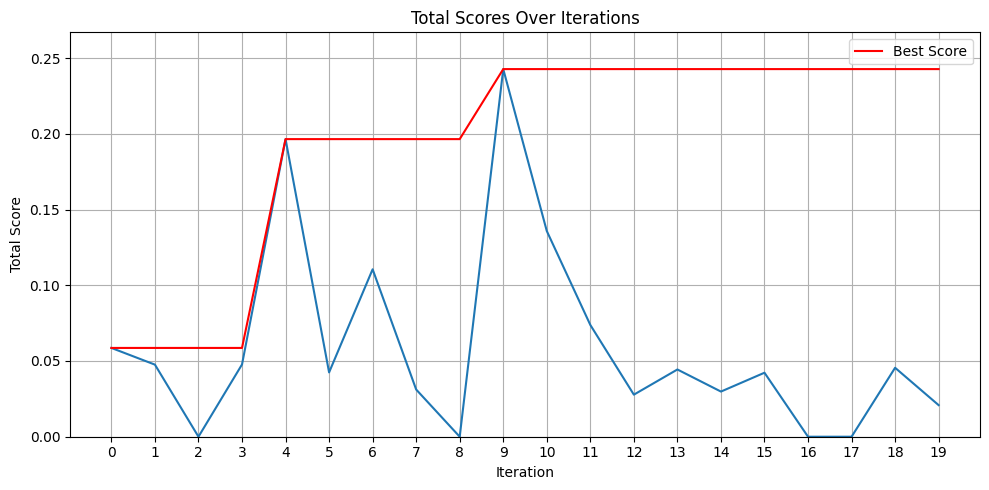

In [10]:
import matplotlib.pyplot as plt

total_scores = [d['total_score'] for d in newy]
best_scores= [0]
for d in newy:
    best_scores.append(max(best_scores[-1], d['total_score']))
best_scores = best_scores[1:]  # 最初の値を削除

plt.figure(figsize=(10, 5))
plt.title('Total Scores Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Total Score')
plt.xticks(range(len(total_scores)))
plt.grid(True)
plt.ylim(0, max(total_scores) * 1.1)  # 上限値を設定
plt.plot(total_scores)
plt.plot(best_scores, linestyle='-', color='red', label='Best Score')
plt.legend()
plt.tight_layout()

### 1度だけ回す

ブラックボックス最適化においてはブラックボックス関数が実験が必要だったりでコードの中に関数として持ち込めない場合があります。　　
その場合は`.run`メソッドの`n_iter=1`を指定して1度だけ回すことができます。
この時はブラックボックス関数を渡さなくても良いです。

In [11]:
newX, newy = bb_opt.run(
    n_iter=1
)
newX

  0%|          | 0/100 [00:00<?, ?it/s]

/Users/yuyamashiro/workspace/JijZeptTools/.venv/lib/python3.11/site-packages/ommx_pyscipopt_adapter/adapter.py:30: UserWarning: linked SCIP 9.02 is not recommended for this version of PySCIPOpt - use version 9.2.1
  self.model = pyscipopt.Model()


[{'bidding_strategy': 'CPC',
  'targeting_granularity': 'gender_only',
  'creative_format': 'native',
  'audience_strategy': 'new_acquisition',
  'bid_amount': 500.0,
  'target_age_range': 10.0,
  'frequency_cap': 'daily_3',
  'time_slot': 'weekday_daytime',
  'budget_allocation': 2.0,
  'device_target': 'mobile'}]

In [12]:
newy # ブラックボックス関数を渡していないので空です。

[]

## 制約条件を陽に記述する

この広告は新シミュレータでは実は以下の制約条件があり、これを満たしていない時はスコアが0になります。

- 動画広告の場合は予算配分を多め (0.8以上) にする必要がある

これを明示的に設定しておきましょう。`BlackboxProblem`の`.problem`に制約条件を追加してください。

カテゴリ変数はバイナリ変数とOnehot制約で表されています。

また、`creative_format`のカテゴリーを`['banner', 'video', 'native', 'rich_media']`として設定しているので`video`が設定されているかどうかは`creative_format[1]`が1か0かで判断できます。  
これを用いて以下のように制約条件を実装します。


In [13]:
bb_model.problem += jm.Constraint(
    "budget constraint",
    0.8*creative_format[1] <= budget_allocation
)

### 制約条件付きでブラックボックス最適化を実行

In [14]:
bb_opt = BlackboxOptimization(bb_model)
bb_opt.setup((init_dataset, init_evals), objectives=["total_score"])

newX, newy = bb_opt.run(
    n_iter=20,
    blackbox_func=ad_campaign_blackbox_func,
)

/Users/yuyamashiro/workspace/JijZeptTools/.venv/lib/python3.11/site-packages/torch/utils/data/dataset.py:473: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

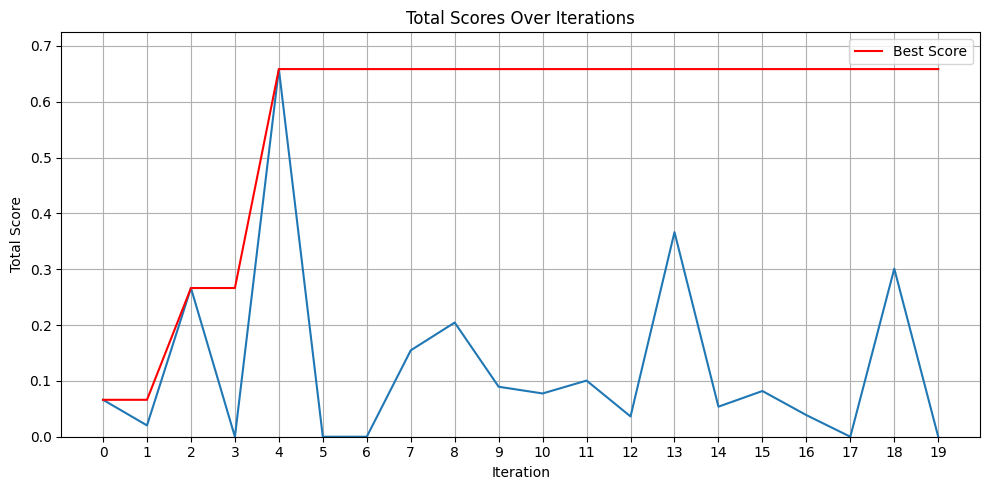

In [15]:
total_scores = [d["total_score"] for d in newy]
best_scores = [0]
for d in newy:
    best_scores.append(max(best_scores[-1], d["total_score"]))
best_scores = best_scores[1:]  # 最初の値を削除

plt.figure(figsize=(10, 5))
plt.title("Total Scores Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Total Score")
plt.xticks(range(len(total_scores)))
plt.grid(True)
plt.ylim(0, max(total_scores) * 1.1)  # 上限値を設定
plt.plot(total_scores)
plt.plot(best_scores, linestyle="-", color="red", label="Best Score")
plt.legend()
plt.tight_layout()

制約条件を追加したことでコスト0が出にくくなったことが確認できるはずです。

ブラックボックス最適化とはいえ、自明なもしくはドメイン知識からわかる制約条件を追加しておくことで安定した結果が得られることが多いです。

内部のアルゴリズムの挙動によっては後処理が入るため、制約条件を追加しても制約を破る解に変更されてしまっている場合があります。
